<a href="https://colab.research.google.com/github/m-aman-chaudhry/AI-based-GameBots/blob/main/DOOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing system dependencies for VizDoom

In [ ]:
!sudo apt-get update
!sudo apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev libopenal-dev timidity libwildmidi-dev unzip
!sudo apt-get install libboost-all-dev
!apt-get install liblua5.1-dev
!sudo apt-get install cmake libboost-all-dev libgtk2.0-dev libsdl2-dev python-numpy git
!git clone https://github.com/shakenes/vizdoomgym.git
!python3 -m pip install -e vizdoomgym/
!pip install pillow
!pip install gym==0.15.3

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libbz2-dev is already the newest version (1.0.8-2).
libjpeg-dev is already the newest version (8c-2ubun

## ------------------------- IMAGE PREPROCESSING (image_preprocessing.py) -------------------------

### Importing the libraries

In [ ]:
import numpy as np
import cv2
from gym.core import ObservationWrapper
from gym.spaces.box import Box

### Preprocessing the images

In [ ]:
class PreprocessImage(ObservationWrapper):
    
    def __init__(self, env, height = 64, width = 64, grayscale = True, crop = lambda img: img):
        super(PreprocessImage, self).__init__(env)
        self.img_size = (height, width)
        self.grayscale = grayscale
        self.crop = crop
        n_colors = 1 if self.grayscale else 3
        self.observation_space = Box(0.0, 1.0, [n_colors, height, width])

    def observation(self, img):
        img = self.crop(img)
        img = cv2.resize(img, self.img_size)
        if self.grayscale:
            img = img.mean(-1, keepdims = True)
        img = np.transpose(img, (2, 0, 1))
        img = img.astype('float32') / 255.
        return img

## ------------------------- EXPERIENCE REPLAY (experience_replay.py) -------------------------

### Importing the libraries

In [ ]:
import numpy as np
from collections import namedtuple, deque

### Defining One Step

In [ ]:
Step = namedtuple('Step', ['state', 'action', 'reward', 'done'])

### Making the AI progress on several (n_step) steps

In [ ]:
class NStepProgress:
    
    def __init__(self, env, ai, n_step):
        self.ai = ai
        self.rewards = []
        self.env = env
        self.n_step = n_step
    
    def __iter__(self):
        state = self.env.reset()
        history = deque()
        reward = 0.0
        while True:
            action = self.ai(np.array([state]))[0][0]
            next_state, r, is_done, _ = self.env.step(action)
            reward += r
            history.append(Step(state = state, action = action, reward = r, done = is_done))
            while len(history) > self.n_step + 1:
                history.popleft()
            if len(history) == self.n_step + 1:
                yield tuple(history)
            state = next_state
            if is_done:
                if len(history) > self.n_step + 1:
                    history.popleft()
                while len(history) >= 1:
                    yield tuple(history)
                    history.popleft()
                self.rewards.append(reward)
                reward = 0.0
                state = self.env.reset()
                history.clear()
    
    def rewards_steps(self):
        rewards_steps = self.rewards
        self.rewards = []
        return rewards_steps

### Implementing Experience Replay

In [ ]:
class ReplayMemory:
    
    def __init__(self, n_steps, capacity = 10000):
        self.capacity = capacity
        self.n_steps = n_steps
        self.n_steps_iter = iter(n_steps)
        self.buffer = deque()

    def sample_batch(self, batch_size): # creates an iterator that returns random batches
        ofs = 0
        vals = list(self.buffer)
        np.random.shuffle(vals)
        while (ofs+1)*batch_size <= len(self.buffer):
            yield vals[ofs*batch_size:(ofs+1)*batch_size]
            ofs += 1

    def run_steps(self, samples):
        while samples > 0:
            entry = next(self.n_steps_iter) # 10 consecutive steps
            self.buffer.append(entry) # we put 200 for the current episode
            samples -= 1
        while len(self.buffer) > self.capacity: # we accumulate no more than the capacity (10000)
            self.buffer.popleft()

## ------------------------- AI FOR DOOM (ai.py) -------------------------

### Importing the libraries

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

### Importing the packages for OpenAI and Doom

In [ ]:
import gym
import vizdoomgym
from gym import wrappers

## Part 1 - Building the AI

### Making the Brain

In [ ]:
class CNN(nn.Module):
    
    def __init__(self, number_actions):
        super(CNN, self).__init__()
        self.convolution1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5)
        self.convolution2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3)
        self.convolution3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2)
        self.fc1 = nn.Linear(in_features = self.count_neurons((1, 256, 256)), out_features = 40)
        self.fc2 = nn.Linear(in_features = 40, out_features = number_actions)

    def count_neurons(self, image_dim):
        x = Variable(torch.rand(1, *image_dim))
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        return x.data.view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.convolution1(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution2(x), 3, 2))
        x = F.relu(F.max_pool2d(self.convolution3(x), 3, 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Making the Body

In [ ]:
class SoftmaxBody(nn.Module):
    
    def __init__(self, T):
        super(SoftmaxBody, self).__init__()
        self.T = T

    def forward(self, outputs, number_actions=1):
        probs = F.softmax(outputs * self.T)  
        actions = probs.multinomial(num_samples=number_actions)
        return actions

### Making the AI

In [ ]:
class AI:

    def __init__(self, brain, body):
        self.brain = brain
        self.body = body

    def __call__(self, inputs):
        input = Variable(torch.from_numpy(np.array(inputs, dtype = np.float32)))
        output = self.brain(input)
        actions = self.body(output)
        return actions.data.numpy()

## Part 2 - Training the AI with Deep Convolutional Q-Learning

### Getting the Doom environment

In [ ]:
doom_env = PreprocessImage(gym.make('VizdoomCorridor-v0'), width = 256, height = 256, grayscale = True)
doom_env = wrappers.Monitor(doom_env, "videos", force = True)
number_actions = doom_env.action_space.n

Cannot connect to "None"


### Building an AI

In [ ]:
cnn = CNN(number_actions)
softmax_body = SoftmaxBody(T = 1.0)
ai = AI(brain = cnn, body = softmax_body)

### Setting up Experience Replay

In [ ]:
n_steps = NStepProgress(env = doom_env, ai = ai, n_step = 10)
memory = ReplayMemory(n_steps = n_steps, capacity = 10000)

### Implementing Eligibility Trace

In [ ]:
def eligibility_trace(batch):
    gamma = 0.99
    inputs = []
    targets = []
    for series in batch:
        input = Variable(torch.from_numpy(np.array([series[0].state, series[-1].state], dtype = np.float32)))
        output = cnn(input)
        cumul_reward = 0.0 if series[-1].done else output[1].data.max()
        for step in reversed(series[:-1]):
            cumul_reward = step.reward + gamma * cumul_reward
        state = series[0].state
        target = output[0].data
        target[series[0].action] = cumul_reward
        inputs.append(state)
        targets.append(target)
    return torch.from_numpy(np.array(inputs, dtype = np.float32)), torch.stack(targets)

### Making the moving average on 100 steps

In [ ]:
class MA:
    def __init__(self, size):
        self.list_of_rewards = []
        self.size = size
    def add(self, rewards):
        if isinstance(rewards, list):
            self.list_of_rewards += rewards
        else:
            self.list_of_rewards.append(rewards)
        while len(self.list_of_rewards) > self.size:
            del self.list_of_rewards[0]
    def average(self):
        return np.mean(self.list_of_rewards)
ma = MA(100)

### Training the AI

In [ ]:
loss = nn.MSELoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.001)
nb_epochs = 20
for epoch in range(1, nb_epochs + 1):
    memory.run_steps(samples=200)
    for batch in memory.sample_batch(128):
        inputs, targets = eligibility_trace(batch)
        inputs, targets = Variable(inputs), Variable(targets)
        predictions = cnn(inputs)
        loss_error = loss(predictions, targets)
        optimizer.zero_grad()
        loss_error.backward()
        optimizer.step()
    rewards_steps = n_steps.rewards_steps()
    ma.add(rewards_steps)
    avg_reward = ma.average()
    print("Epoch: %s, Average Reward: %s" % (str(epoch), str(avg_reward)))

<ipython-input-10-55282bbae7f8>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs * self.T)


Epoch: 1, Average Reward: -105.13813781738281
Epoch: 2, Average Reward: -61.94831466674805
Epoch: 3, Average Reward: 24.67827860514323
Epoch: 4, Average Reward: 71.91016693115235
Epoch: 5, Average Reward: 103.56937299455915
Epoch: 6, Average Reward: 136.2706002628102
Epoch: 7, Average Reward: 111.40022036903783
Epoch: 8, Average Reward: 96.42361450195312
Epoch: 9, Average Reward: 105.49610107421876
Epoch: 10, Average Reward: 102.219074955693
Epoch: 11, Average Reward: 106.25660654703776
Epoch: 12, Average Reward: 121.00399132930872
Epoch: 13, Average Reward: 135.69199159410266
Epoch: 14, Average Reward: 146.69099778395432
Epoch: 15, Average Reward: 149.80578540620348
Epoch: 16, Average Reward: 156.47928059895833
Epoch: 17, Average Reward: 168.12401207457197
Epoch: 18, Average Reward: 160.54471852828044
Epoch: 19, Average Reward: 156.86369441105768
Epoch: 20, Average Reward: 165.58479114879262


### Importing the libraries

In [ ]:
import os
import cv2
import glob
import gym
import vizdoomgym
import matplotlib.pyplot as plt
from collections import Counter
from gym.wrappers import Monitor

### Printing the input shape and number of possible actions

In [ ]:
env = gym.make('VizdoomCorridor-v0')
action_num = env.action_space.n
print("Number of possible actions: ", action_num)
state = env.reset()
state, reward, done, info = env.step(env.action_space.sample())
print(state.shape)
env.close()

Number of possible actions:  7
(240, 320, 3)


### Displaying a frame of the environment just to see how it is like

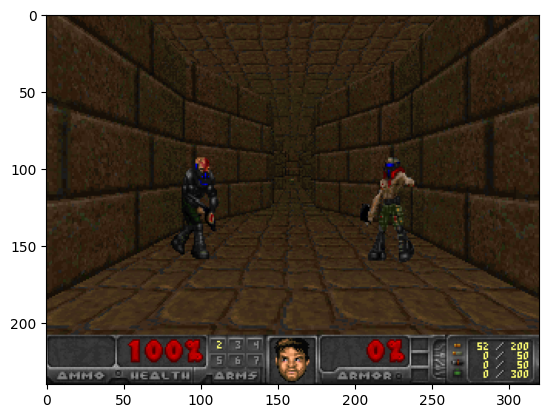

(240, 320, 3)


In [ ]:
observation = env.reset()
plt.imshow(observation)
plt.show()
print(observation.shape)

### Making a helper function for the visualization

In [ ]:
def wrap_env(env):
  env = Monitor(env, './vid',video_callable=lambda episode_id:True, force=True)
  return env

### Running the AI on one episode

In [ ]:
gym_env = PreprocessImage(gym.make('VizdoomCorridor-v0'), width = 256, height = 256, grayscale = True)
gym_env = wrappers.Monitor(gym_env, "videos", force = True)
environment = wrap_env(gym_env)
done = False
observation = environment.reset()
new_observation = observation
actions_counter = Counter()
prev_input = None
img_array=[]
while True:
    # Feeding the game screen and getting the Q values for each action
    actions = cnn(Variable(Variable(torch.from_numpy(observation.reshape(1, 1, 256, 256)))))
    # Getting the action
    action = np.argmax(actions.detach().numpy(), axis=-1)
    actions_counter[str(action)] += 1 
    # Selecting the action using epsilon greedy policy
    environment.render()
    observation = new_observation        
    # Now performing the action and moving to the next state, next_obs, receive reward
    new_observation, reward, done, _ = environment.step(action)
    img_array.append(new_observation)
    if done: 
        # observation = env.reset()
        break
environment.close()

### Outputting the video of the gameplay

In [ ]:
folder_name = "gameplay_frames"
video_name = "agent_gameplay.avi"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

for i in range(len(img_array)):
    plt.imsave("{}/{}_frame.jpg".format(folder_name, i), img_array[i].reshape(256, 256))

files = glob.glob(os.path.expanduser("{}/*".format(folder_name)))
frames_array = []

for filename in sorted(files, key=lambda t: os.stat(t).st_mtime):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    frames_array.append(img)

out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(frames_array)):
    out.write(frames_array[i])

out.release()